# Gerekli Kütüphaneler

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings('ignore')


# Görsel Ayarları

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


# Veri Yükleme

In [3]:
dosya_yolu = r"C:\Users\Fatih\Downloads\insurance.csv"
df = pd.read_csv(dosya_yolu)
print("Veri seti yüklendi:", df.shape)

Veri seti yüklendi: (1338, 7)


# Eksik Veri Kontrolü

In [5]:
print("\n" + "="*50)
print("EKSİK VERİ KONTROLÜ")
print("="*50)
print(df.isnull().sum())


EKSİK VERİ KONTROLÜ
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


# Aykırı Değer Kontrolü

In [6]:
numeric_features = ['age', 'bmi', 'children', 'charges']

for col in numeric_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1-1.5*IQR) | (df[col] > Q3+1.5*IQR)]
    print(f"{col}: {len(outliers)} aykırı değer (%{len(outliers)/len(df)*100:.2f})")

age: 0 aykırı değer (%0.00)
bmi: 9 aykırı değer (%0.67)
children: 0 aykırı değer (%0.00)
charges: 139 aykırı değer (%10.39)


# Veri Dönüşümü

In [7]:
df['sex_encoded'] = df['sex'].map({'female': 0, 'male': 1})
df['smoker_encoded'] = df['smoker'].map({'no': 0, 'yes': 1})
df = pd.get_dummies(df, columns=['region'], prefix='region', drop_first=True)


# Korelasyon Analizi

PermissionError: [Errno 13] Permission denied: 'correlation_matrix.png'

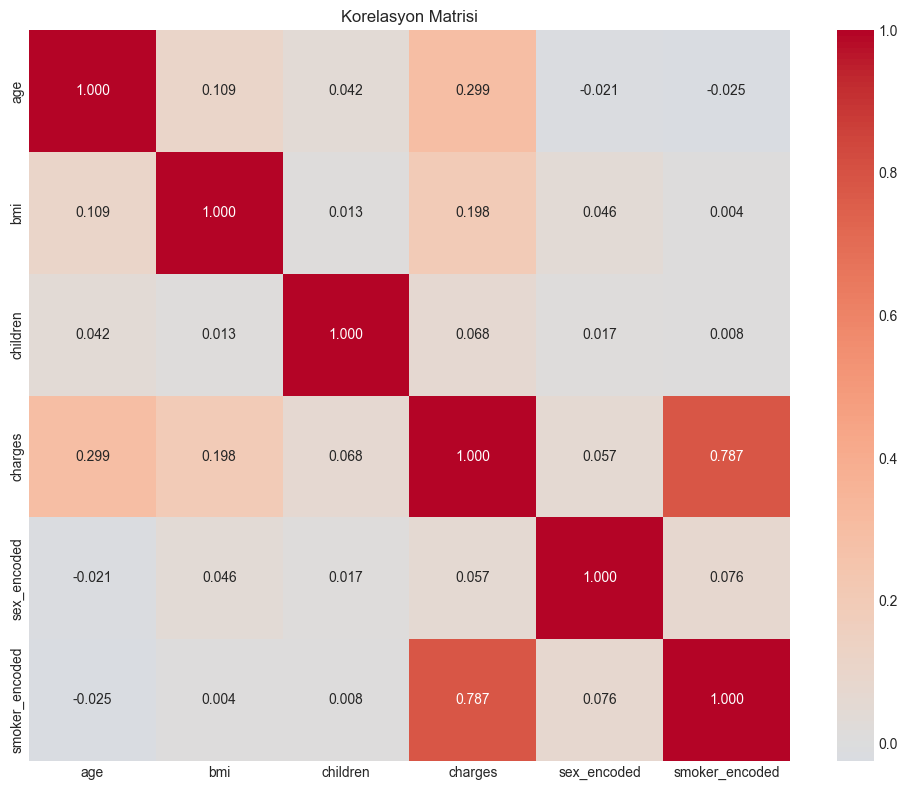

In [8]:
numeric_cols = ['age', 'bmi', 'children', 'charges', 'sex_encoded', 'smoker_encoded']
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Korelasyon Matrisi')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()


# Train-Test Oluşturma

In [9]:
X = df[['age', 'bmi', 'children', 'sex_encoded', 'smoker_encoded',
        'region_northwest', 'region_southeast', 'region_southwest']]
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Model Oluşturma

In [10]:
model = LinearRegression()
model.fit(X_train, y_train)

# Statsmodels ile detaylı analiz
X_train_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_sm).fit()
print("\n" + "="*50)
print("MODEL ÖZETİ")
print("="*50)
print(model_sm.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

# VİF Kontrolü


In [11]:
vif_data = pd.DataFrame()
vif_data["Değişken"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\n" + "="*50)
print("VIF ANALİZİ")
print("="*50)
print(vif_data.sort_values('VIF', ascending=False))

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

# Varsayım Kontrolleri

# Residuals

In [13]:
y_pred_train = model.predict(X_train)
residuals = y_train - y_pred_train

# Shapiro-Wilk Testi

In [14]:
stat, p = shapiro(residuals[:5000])
print(f"\nShapiro-Wilk Test: stat={stat:.4f}, p={p:.6f}")



Shapiro-Wilk Test: stat=0.8944, p=0.000000


# Durbin-Watson Testi


In [15]:
dw = durbin_watson(residuals)
print(f"Durbin-Watson: {dw:.4f}")

Durbin-Watson: 2.0854


# Breusch-Pagan Testi


In [16]:
bp_test = het_breuschpagan(residuals, X_train_sm)
print(f"Breusch-Pagan p-value: {bp_test[1]:.6f}")

Breusch-Pagan p-value: 0.000000


# Model Değerlendirme

In [17]:
y_pred_test = model.predict(X_test)

print("\n" + "="*50)
print("MODEL PERFORMANSI")
print("="*50)
print(f"R² Score: {r2_score(y_test, y_pred_test):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")


MODEL PERFORMANSI
R² Score: 0.7836
RMSE: 5796.28
MAE: 4181.19


# Görselleştirmeler

PermissionError: [Errno 13] Permission denied: 'residual_analysis.png'

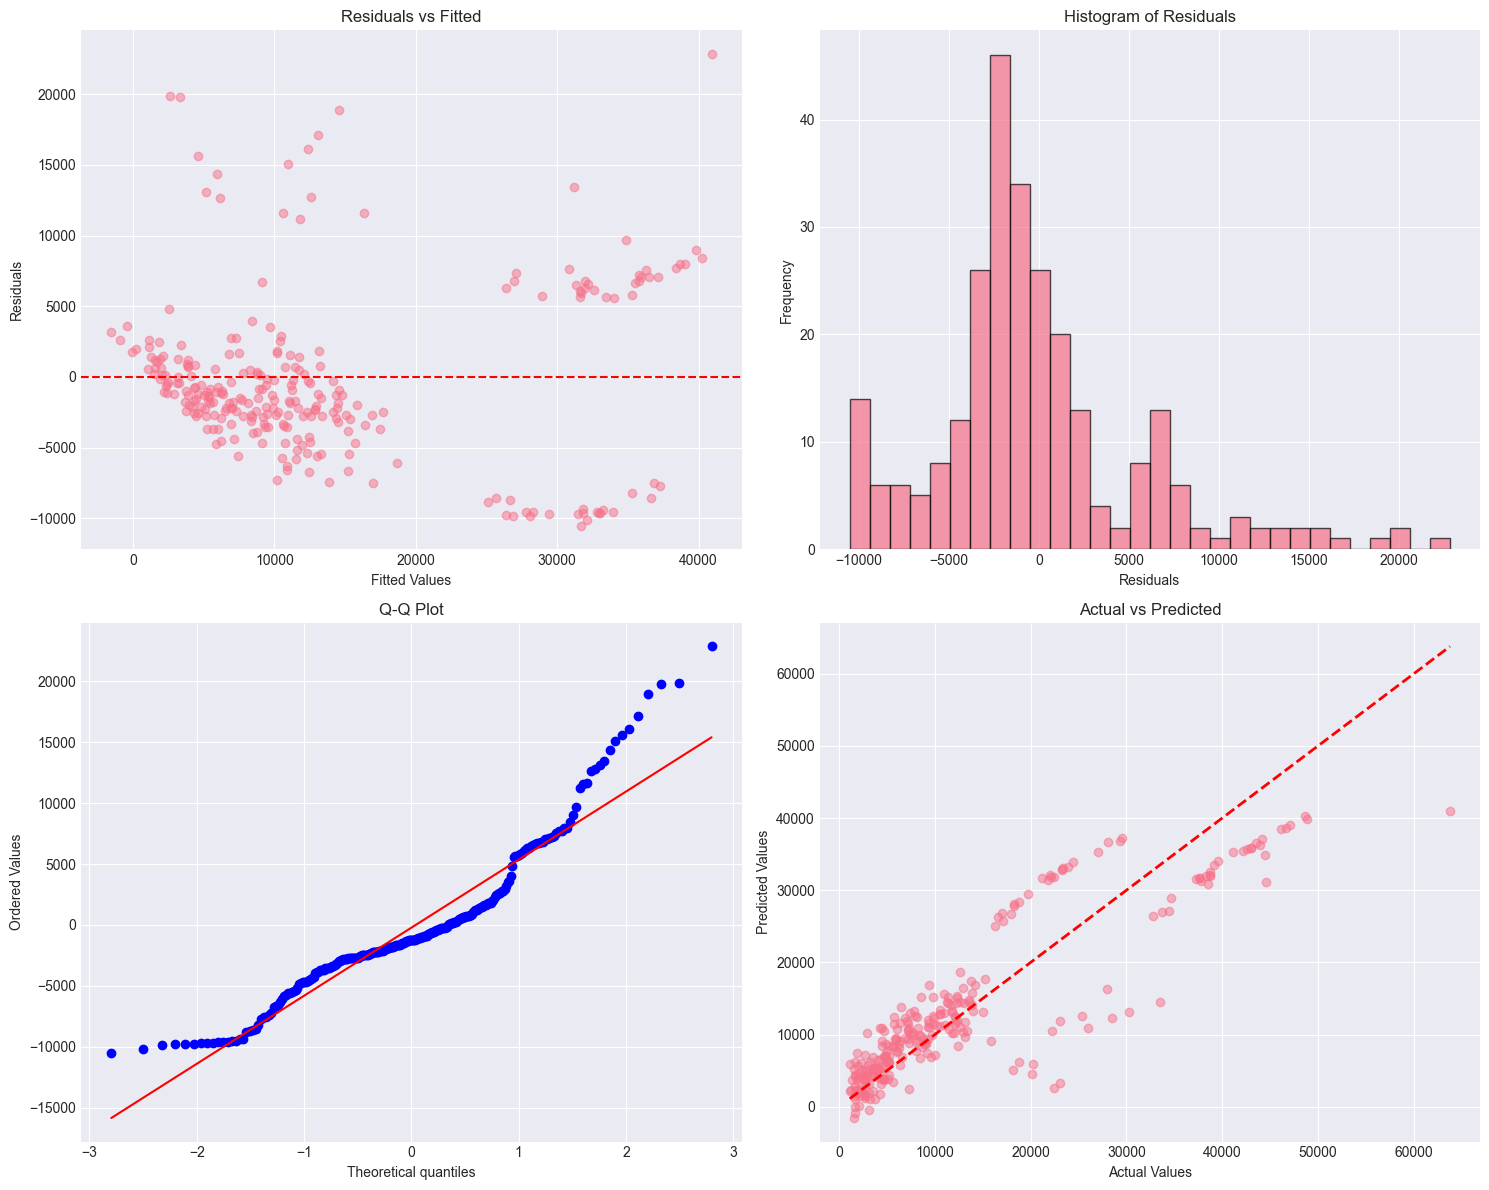

In [18]:
# Residual Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

residuals_test = y_test - y_pred_test

axes[0, 0].scatter(y_pred_test, residuals_test, alpha=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted')

axes[0, 1].hist(residuals_test, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Histogram of Residuals')

stats.probplot(residuals_test, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

axes[1, 1].scatter(y_test, y_pred_test, alpha=0.5)
axes[1, 1].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].set_title('Actual vs Predicted')

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=300)
plt.show()

print("\n✓ Analiz tamamlandı! Tüm görseller kaydedildi.")